# Manipulating Hierarchies in Atoti

In this notebook, we'll show you a few tips for manipulating hierarchies in Atoti to serve your analytical needs. In particular, we'll discuss some of the basic properties of hierarchies, along with some of the nuances for working with the following types of hierarchies:

* Multi-level hierarchies
* Slicing hierarchies
* Virtual hierarchies

💡 **Note:** Still getting familiar with hierarchies in Atoti? Make sure to visit the [Hierarchy Fundamentals in Atoti](../main.ipynb) notebook for a basic introduction.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=hierarchy-manipulations" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

## Set up the Atoti data model and cube

First things first, let's set up our data model and cube in Atoti. As we continue our exploration of hierarchies in Atoti, we'll utilize the same cube that we set up in the previous notebook: [Hierarchy Fundamentals in Atoti](../hierarchies/main.ipynb).

To do this, we've created a [setup.py](utils/setup.py) script that automates some of the prerequisite steps. 

In [1]:
import atoti as tt
from utils import setup

cube, session = setup.main()

## Analyze the Atoti cube

Now that the data has been loaded into the cube, let's take a look at the data model of the cube to confirm we have things set up properly. And as always, we can alias the hierarchies, levels, and measures as new variables for enhanced readability when manipulating these components of the cube.

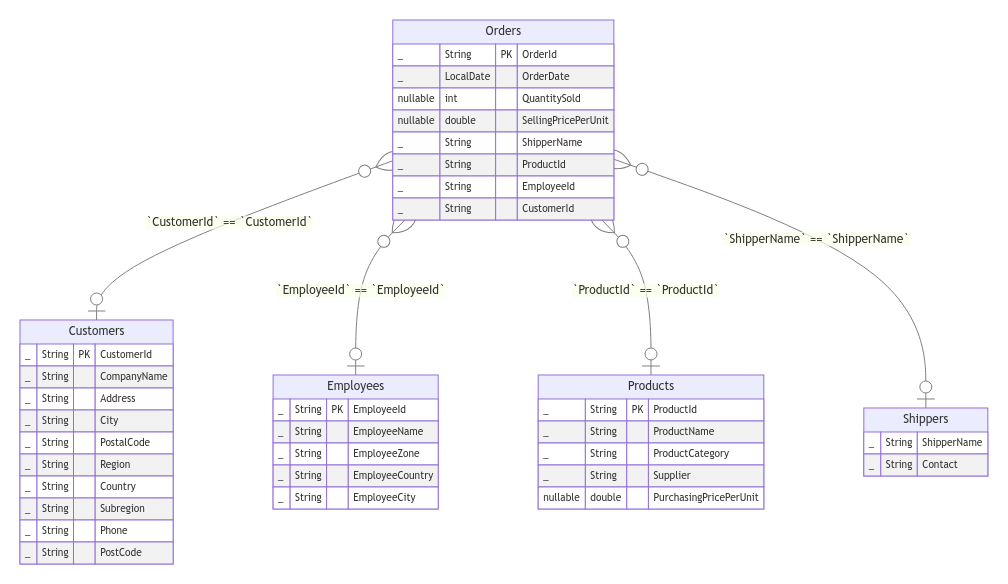

In [2]:
# View the schema of the data model
session.tables.schema

In [3]:
# Set variables for hierarchies, levels, and measures
h, l, m = cube.hierarchies, cube.levels, cube.measures

## Viewing hierarchies

Great, looks like we're set up. Let's now take a look at the list of our hierarchies to see which ones we can manipulate.

In [4]:
h

{('Products', 'Supplier'): <atoti.hierarchy.Hierarchy object at 0x16a9e9000>, ('Orders', 'OrderDate'): <atoti.hierarchy.Hierarchy object at 0x16a9ebb50>, ('Orders', 'ProductId'): <atoti.hierarchy.Hierarchy object at 0x16a9ebc40>, ('Products', 'ProductName'): <atoti.hierarchy.Hierarchy object at 0x16a9ebd30>, ('Customers', 'Phone'): <atoti.hierarchy.Hierarchy object at 0x16a9ebe20>, ('Customers', 'Address'): <atoti.hierarchy.Hierarchy object at 0x16a9ebf10>, ('Customers', 'Region'): <atoti.hierarchy.Hierarchy object at 0x16a9ebb20>, ('Shippers', 'Contact'): <atoti.hierarchy.Hierarchy object at 0x16aa14130>, ('Orders', 'EmployeeId'): <atoti.hierarchy.Hierarchy object at 0x16aa14220>, ('Customers', 'PostCode'): <atoti.hierarchy.Hierarchy object at 0x16aa14310>, ('Employees', 'EmployeeCountry'): <atoti.hierarchy.Hierarchy object at 0x16aa14400>, ('Products', 'ProductCategory'): <atoti.hierarchy.Hierarchy object at 0x16aa144f0>, ('Customers', 'PostalCode'): <atoti.hierarchy.Hierarchy object at 0x16aa145e0>, ('Customers', 'Subregion'): <atoti.hierarchy.Hierarchy object at 0x16aa146d0>, ('Orders', 'CustomerId'): <atoti.hierarchy.Hierarchy object at 0x16aa147c0>, ('Employees', 'EmployeeCity'): <atoti.hierarchy.Hierarchy object at 0x16aa148b0>, ('Customers', 'Country'): <atoti.hierarchy.Hierarchy object at 0x16aa149a0>, ('Orders', 'OrderId'): <atoti.hierarchy.Hierarchy object at 0x16aa14a90>, ('Customers', 'CompanyName'): <atoti.hierarchy.Hierarchy object at 0x16aa14b80>, ('Orders', 'ShipperName'): <atoti.hierarchy.Hierarchy object at 0x16aa14c70>, ('Employees', 'EmployeeName'): <atoti.hierarchy.Hierarchy object at 0x16aa14d60>, ('Employees', 'EmployeeZone'): <atoti.hierarchy.Hierarchy object at 0x16aa14e50>, ('Customers', 'City'): <atoti.hierarchy.Hierarchy object at 0x16aa14f40>}

## Basic Hierarchy Properties

Each hierarchy is an object of the [atoti.Hierarchy](https://docs.atoti.io/latest/api/atoti.Hierarchy.html#atoti.Hierarchy) class. This means that we are able to interact with and manipulate hierarchies using their associated class properties and functions. A few basic properties are as follows:

* [dimension](#Hierarchy.dimension)
* [dimension_default](#Hierarchy.dimension_default)
* [levels](#Hierarchy.levels)
* [name](#Hierarchy.name)
* [visible](#Hierarchy.visible)

#### `Hierarchy.dimension`

We can use the `dimension` property of a Hierarchy object to determine its parent dimension. For example, we can call the `dimension` property of the `Address` hierarchy to determine that its parent dimension is `Customers`. 

In [5]:
h["Address"].dimension

'Customers'

#### `Hierarchy.dimension_default`

We can also call the `dimension_default` property of a Hierarchy object to determine if a specified hierarchy is the default hierarchy in its parent dimension. For example, if we call of the `dimention_default` property of our `Address` hierarchy, we see the following:

In [6]:
h["Address"].dimension_default

False

The output of the `dimension_default` property for a Hierarchy should be either `True` or `False`. In this case, the `Address` hierarchy of the `Customers` dimension is **not** the default hierarchy for the `Customers` dimension.

So which hierarchy **is** the default hierarchy for the `Customers` dimension? We can create a simple `for` loop to test this. 

💡 **Note:** The `Orders` and `Customers` tables are joined by the common key: `CustomerId`. However, from an Atoti data model perspective, `CustomerId` is a hierarchy present under the base table or `Orders` dimension, and is no longer present as a (redundant) hierarchy under the `Customers` dimension. Therefore, when checking the `Customers` dimension for its default hierarchy, we must filter out the `CustomerId` out from the search criteria — otherwise we get a missing `KeyError`.

In [7]:
def check_default_hierarchy(hierachies, table):
    """Checks for the default hierarchy for an Atoti Table object."""
    dimension = table.name
    for hierarchy in table.columns:
        if hierarchy != "CustomerId":
            print(
                f"h['{dimension}', '{hierarchy}'].dimension_default == {h[dimension, hierarchy].dimension_default}"
            )


customers = session.tables["Customers"]
check_default_hierarchy(h, customers)

h['Customers', 'CompanyName'].dimension_default == False
h['Customers', 'Address'].dimension_default == False
h['Customers', 'City'].dimension_default == False
h['Customers', 'PostalCode'].dimension_default == True
h['Customers', 'Region'].dimension_default == False
h['Customers', 'Country'].dimension_default == False
h['Customers', 'Subregion'].dimension_default == False
h['Customers', 'Phone'].dimension_default == False
h['Customers', 'PostCode'].dimension_default == False


We can see that the default hierarchy for the `Customers` dimension is actually `PostalCode`. If we set another hierarchy under the `Customers` dimension as the default hierarchy, it would look like this:

In [8]:
h["Address"].dimension_default = True

Then, if we re-use the `check_default_hierarchy` function that we defined previously, we can see that the default hierarchy for the `Customers` dimension has indeed been updated.

In [9]:
check_default_hierarchy(h, customers)

h['Customers', 'CompanyName'].dimension_default == False
h['Customers', 'Address'].dimension_default == True
h['Customers', 'City'].dimension_default == False
h['Customers', 'PostalCode'].dimension_default == False
h['Customers', 'Region'].dimension_default == False
h['Customers', 'Country'].dimension_default == False
h['Customers', 'Subregion'].dimension_default == False
h['Customers', 'Phone'].dimension_default == False
h['Customers', 'PostCode'].dimension_default == False


#### `Hierarchy.levels`



The `levels` property allows us to display the available levels for a **particular** hierarchy. To illustrate the benefits of this, let's say we were to print the assigned variable that we used for `cube.levels`. This would show us **all** the available levels for the entire data model.

In [10]:
l

But let's say we wanted to see just the levels for our previous multi-level hierarchy `Product`. Scanning through the fully qualified list of levels may be a bit cumbersome (especially if we have a large amount of levels!). Thus, we can instead use the `levels` property for the multi-level `Product` hierarchy object to only show the levels for that particular hierarchy.

In [11]:
h["Product"] = [l["ProductCategory"], l["ProductId"]]
product_levels = h["Product"].levels

for key in product_levels.keys():
    print(key)

ProductCategory
ProductId


In [12]:
product_levels["ProductCategory"]

In [13]:
product_levels["ProductId"]

#### `Hierarchy.name`

The `name` property will output the name of the hierarchy like so:

In [14]:
h["Address"].name

'Address'

Though this is a bit redundant when we already know the name of the hierarchy. Therefore, using the `name` property may be more helpful when trying to execute a `for` loop to iterate over all hierarchies in an Atoti data model, where we may want the colloquial hierarchy name rather than the fully qualified one (with both the dimension and hierarchy listed).

In [15]:
for key in h.keys():
    print(key)

('Products', 'Supplier')
('Orders', 'OrderDate')
('Orders', 'ProductId')
('Products', 'ProductName')
('Customers', 'Phone')
('Customers', 'Address')
('Customers', 'Region')
('Shippers', 'Contact')
('Orders', 'EmployeeId')
('Customers', 'PostCode')
('Employees', 'EmployeeCountry')
('Products', 'ProductCategory')
('Customers', 'PostalCode')
('Customers', 'Subregion')
('Orders', 'CustomerId')
('Employees', 'EmployeeCity')
('Customers', 'Country')
('Orders', 'OrderId')
('Products', 'Product')
('Customers', 'CompanyName')
('Orders', 'ShipperName')
('Employees', 'EmployeeName')
('Employees', 'EmployeeZone')
('Customers', 'City')


In [16]:
for key in h.keys():
    print(h[key].name)

Supplier
OrderDate
ProductId
ProductName
Phone
Address
Region
Contact
EmployeeId
PostCode
EmployeeCountry
ProductCategory
PostalCode
Subregion
CustomerId
EmployeeCity
Country
OrderId
Product
CompanyName
ShipperName
EmployeeName
EmployeeZone
City


#### `Hierarchy.visible`

The `visible` property will either display or hide a hierarchy from the list of available hierarchies when using Atoti in either the Atoti JupyterLab extension or the Atoti UI. For example, if we look at our data model, we can see the `CustomerId` hierarchy present in the list of available hierarchies.

💡 **Note:** The `visible` property will **not** delete a hierarchy from an Atoti data model, it merely hides it as an available hierarchy in any of our UI interfaces. Programmatically, a hidden hierarchy can still be used.

<img src="https://data.atoti.io/notebooks/hierarchies/images/hierarchies-visible-true.png" alt="hierarchies-visible-true" width="225"/>

If we use `session.widget` to select the `CustomerId` as our hierarchy and `QuantitySold.SUM` as our measure, we can see output as expected.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
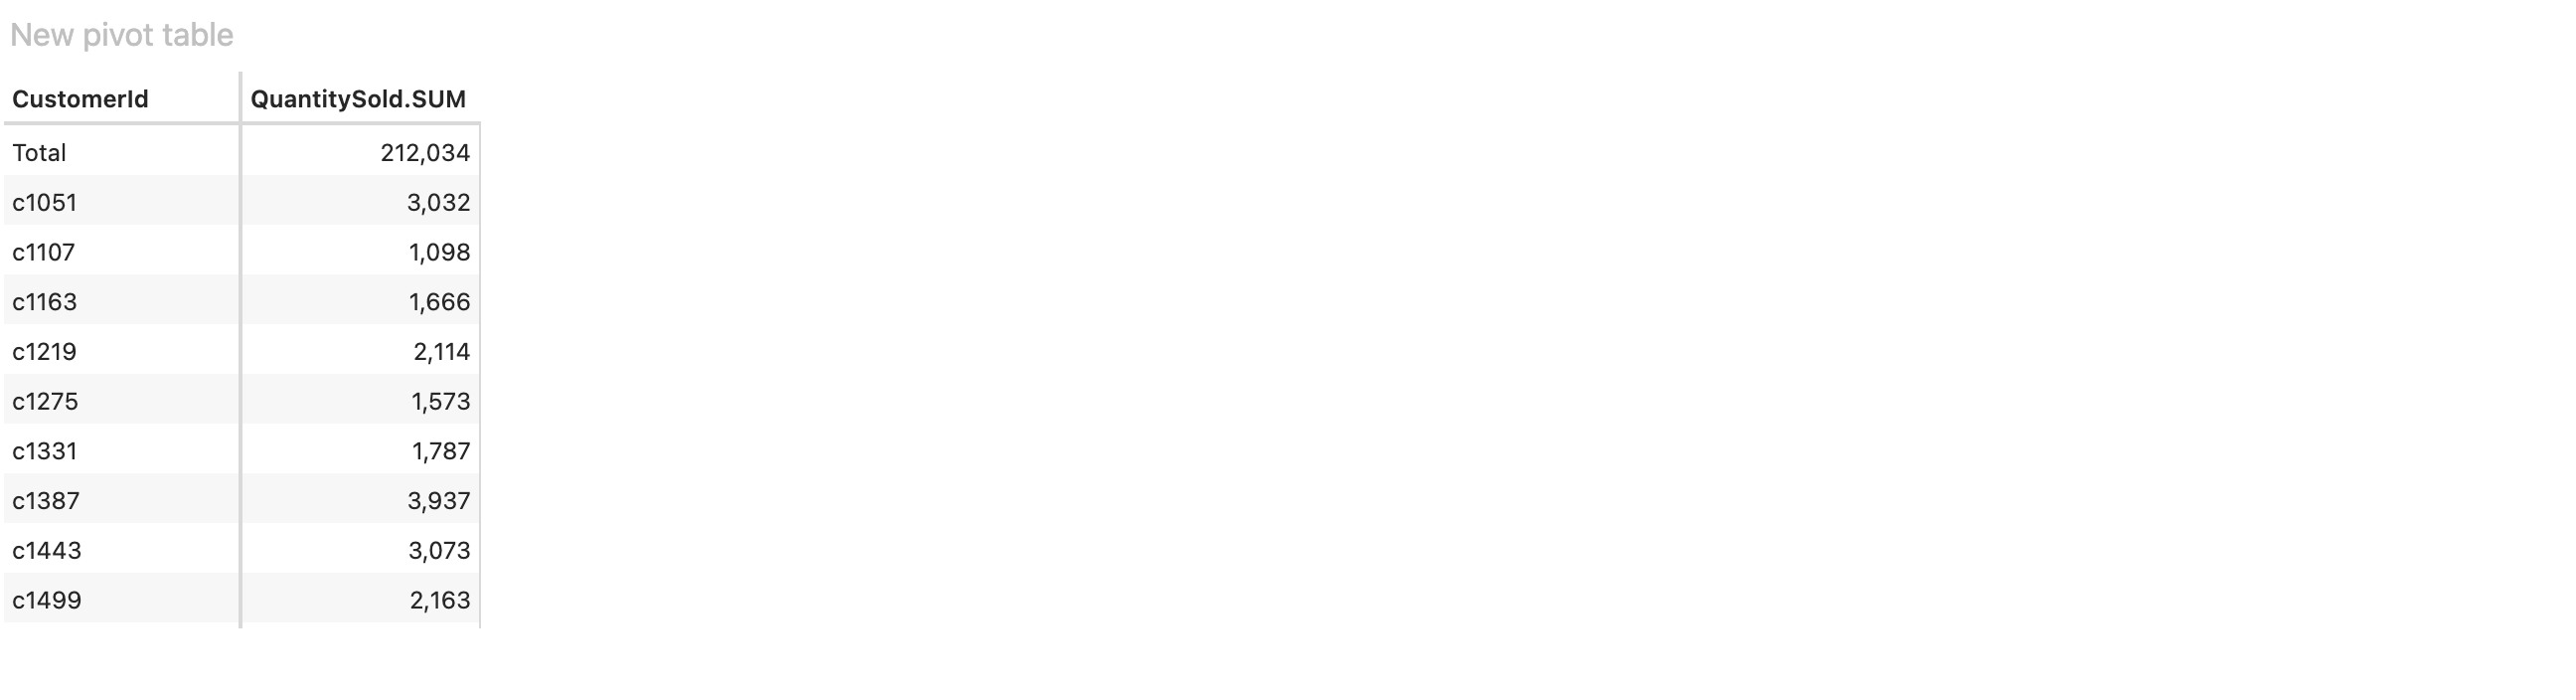

In [17]:
session.widget

However if we set the `visible` property of the `CustomerId` hierarchy to `False`, it will hide it from our list of available hierarchies as expected. 

💡 **Note:** Notice that the total number of hierarchies in the data model (`23`) does not change whether or not the `visible` property for a hierarchy is set to `True` or `False`, and that the previous `session.widget` still shows the analysis for quantity sold per customer, as the hierarchy is not **deleted** but **hidden**.

In [18]:
h["CustomerId"].visible = False

<img src="https://data.atoti.io/notebooks/hierarchies/images/hierarchies-visible-false.png" alt="hierarchies-visible-false" width="225"/>

### Using multi-level hierarchies

Multi-level hierarchies logically group single-level hierarchies together when a parent-child relationship exists among similar single-level hierarchies. As a result, there becomes a concept of shallow-to-deep levels of a multi-level hierarchy.

For example, let's create a multi-level `Geography` hierarchy. 

In [19]:
h["Geography"] = [l["Region"], l["Country"]]
h["Geography"]

Here, we can see that the shallowest level of our multi-level `Geography` hierarchy is our `Region` level, and our deepest level is our `Country` level. This makes sense as countries fall within the umbrella of overarching geographical regions.

To better illustrate this, let's do some quick analysis with our new multi-level `Geography` hierarchy. Here we'll take a look at the total quantity of products sold to customers based in the `Latin America` and `Northern America` regions along with their underlying countries for each region.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
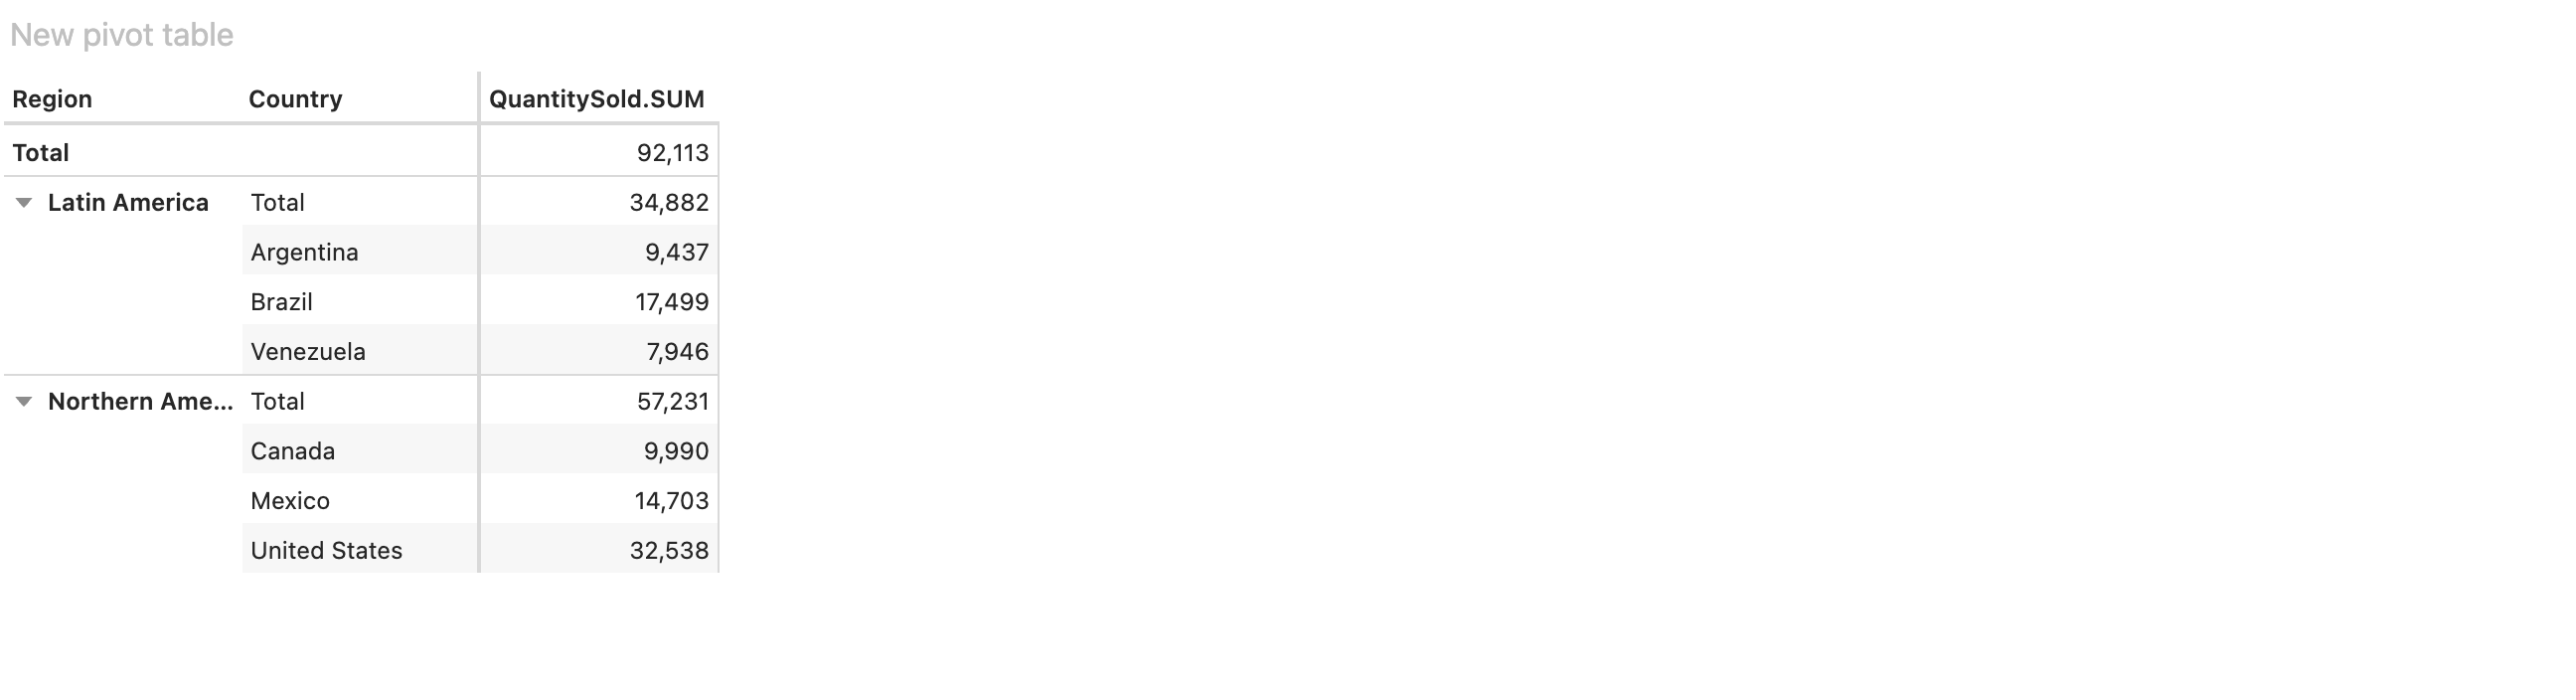

In [20]:
session.widget

However, let's get more specific. Imagine we only wanted the total quantity of products sold to customers in both the entirety of the `Latin America` region in addition to only the more specific country of `United States`.

To do this, we can use the [isin()](https://docs.atoti.io/latest/api/atoti.Hierarchy.isin.html#atoti.Hierarchy.isin) hierarchy function in conjunction with the general [filter](https://docs.atoti.io/latest/api/atoti.filter.html#atoti.filter) function to traverse the variability of shallow to deep levels within a multi-level hierarchy. This looks something like the following:

In [21]:
m["QuantitySold.SUM in Latin America and United States"] = tt.filter(
    m["QuantitySold.SUM"],
    h["Geography"].isin(("Latin America",), ("Northern America", "United States")),
)

Now when we take a look at the values of our new measure, we only see the aggregations for the hierarchy levels specified.

💡 **Note:** We've included our original `QuantitySold.SUM` measure in our analysis as a side-by-side comparison to better illustrate this difference.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
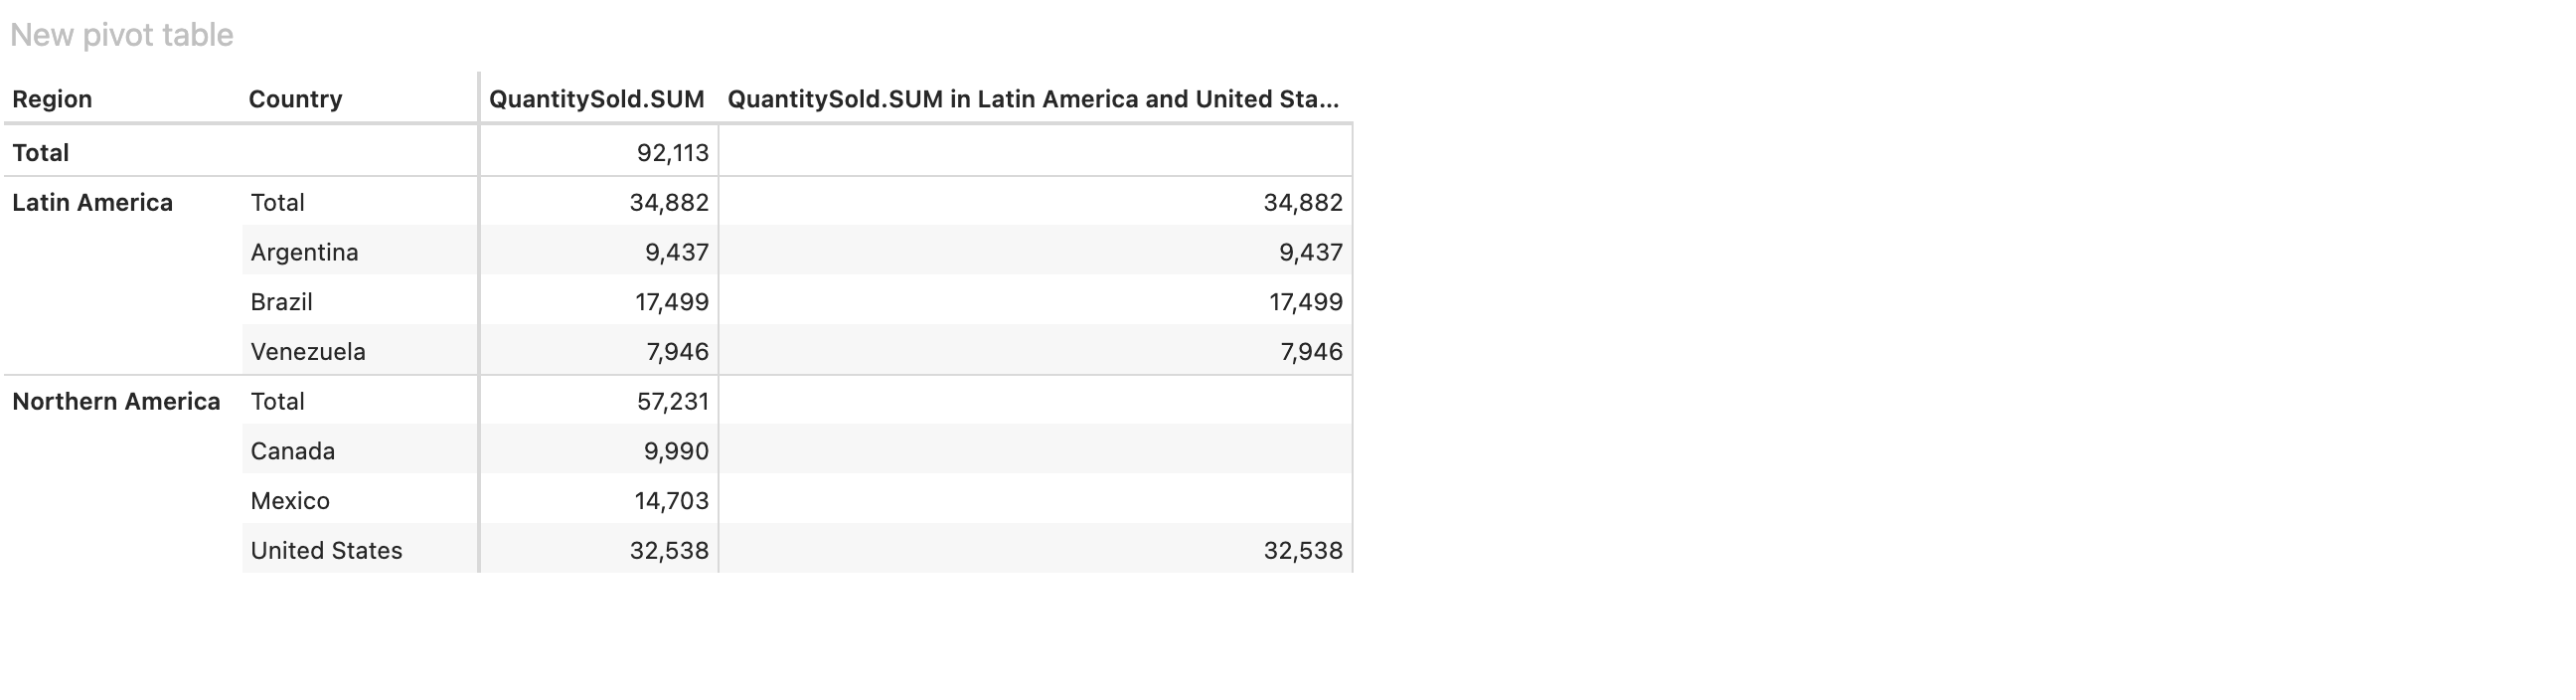

In [22]:
session.widget

### Using slicing hierarchies

Slicing hierarchies are used when we want a hierarchy to no longer be aggregable at the top level/across all members of a hierarchy. For example, imagine we had an `As of Date` hierarchy giving the current product `Inventory` for a given date. It would not provide any meaningful information to aggregate the `Inventory` across all the dates, nor would it be a good use of computational resources.

💡 **Note:** For reference, you would most likely want something like a cumulative aggregation in this case, see [CumulativeScope](https://docs.atoti.io/latest/api/atoti.CumulativeScope.html).

To do this, we can use the [slicing](https://docs.atoti.io/latest/api/atoti.Hierarchy.slicing.html) hierarchy property, which when assigned either `True` or `False` determines whether the hierarchy is a slicing hierachy or not, respectively. To better illustrate this concept, let's consider the [create_parameter_hierarchy_from_column](https://docs.atoti.io/latest/api/atoti.Cube.create_parameter_hierarchy_from_column.html#atoti.Cube.create_parameter_hierarchy_from_column) cube function that creates a slicing hierarchy by default.


To start off, here we see the total quantity of products sold by each employee, as well as the total quantity of products sold for all employees globally.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
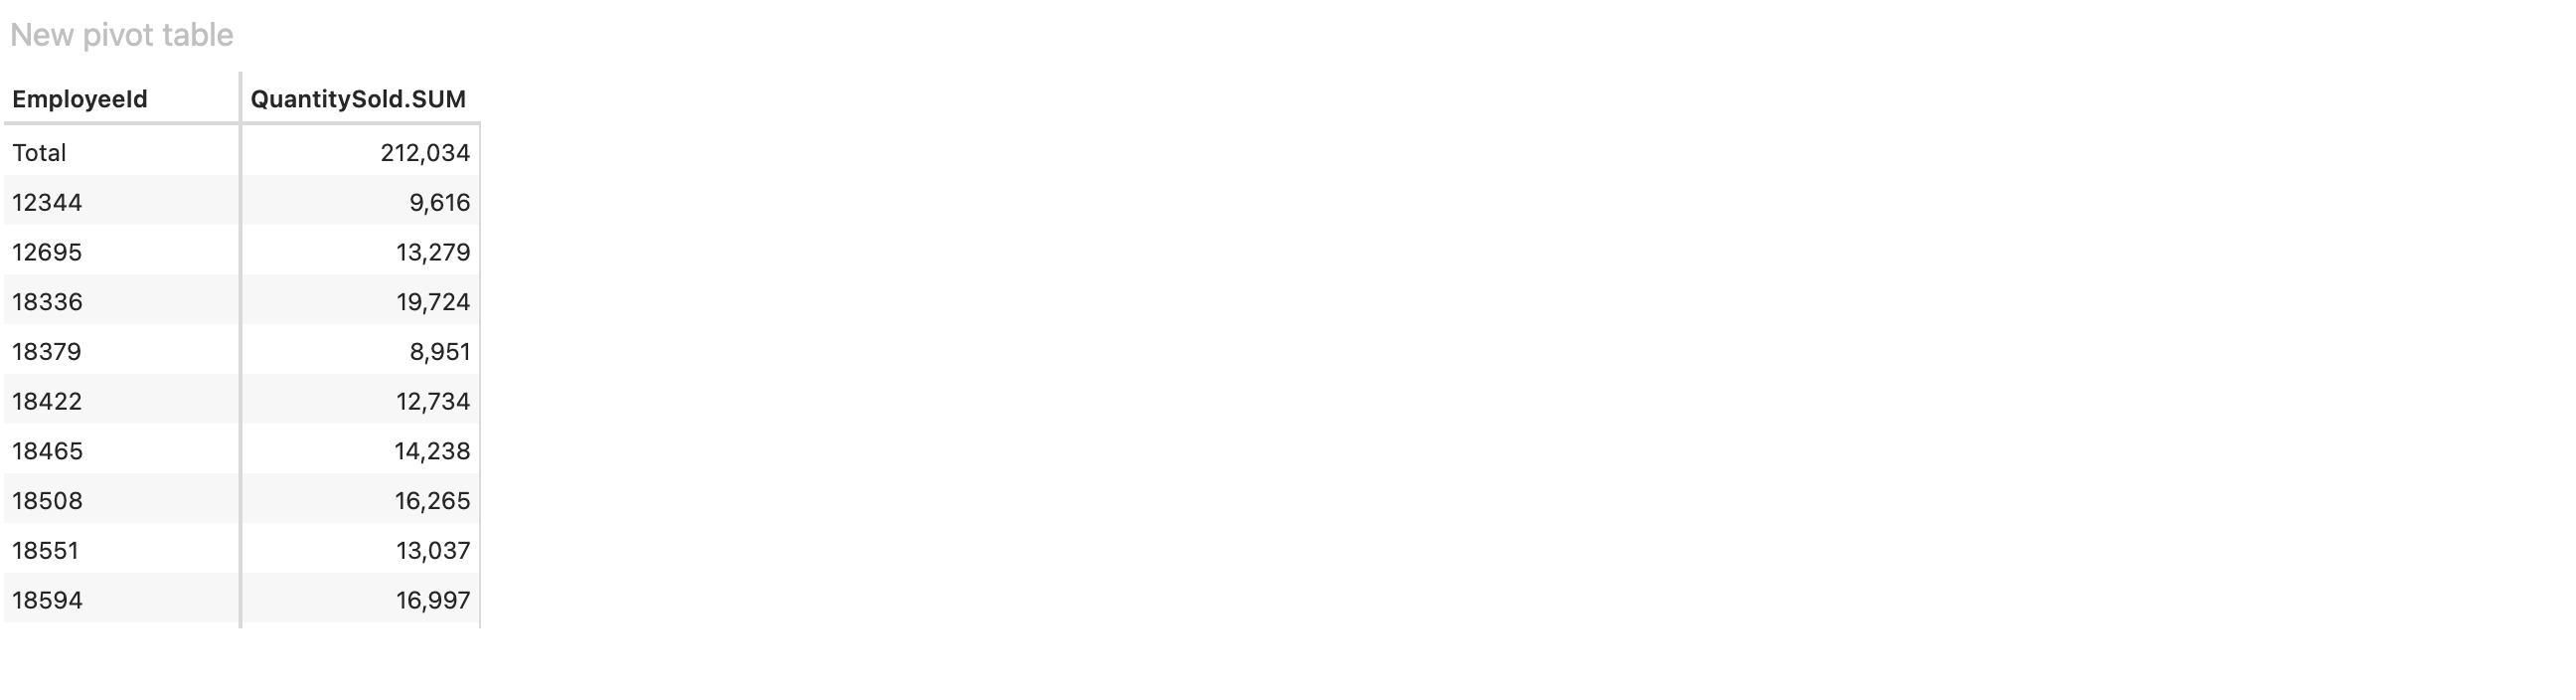

In [23]:
session.widget

Now, let's imagine we wanted to compare the total quantity of products sold by each employee to a specified employee, for all members of our `EmployeeId` hierarchy. This is where using a parameter hierarchy, or a single-level hierarchy that can dynamically set its members comes into play.

If we create a parameter hierarchy called `Employee Comparison`, along with a new product quantity sold measure that allows selecting a employee ID to compare against, we can compare the aggregate values for number of products sold for every member in the `EmployeeId` hierarchy against a specified member, like so.

> **Note:** See our documentation for more info on using the [at](https://docs.atoti.io/latest/api/atoti.at.html#atoti.at) function, which returns a measure equal to the passed measure at specified coordinates of the cube.

In [24]:
employees_table = session.tables["Employees"]
cube.create_parameter_hierarchy_from_column(
    "Employee Comparison", employees_table["EmployeeId"]
)
m["Employee Comparison of Quantity Sold"] = tt.at(
    m["QuantitySold.SUM"], l["EmployeeId"] == l["Employee Comparison"]
)

This would look something like the following.

> 💡 **Note:** Feel free to change the widget filter for `Employee Comparison` to dynamically select a new member of the `EmployeeID` hierarchy for comparative analysis!

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
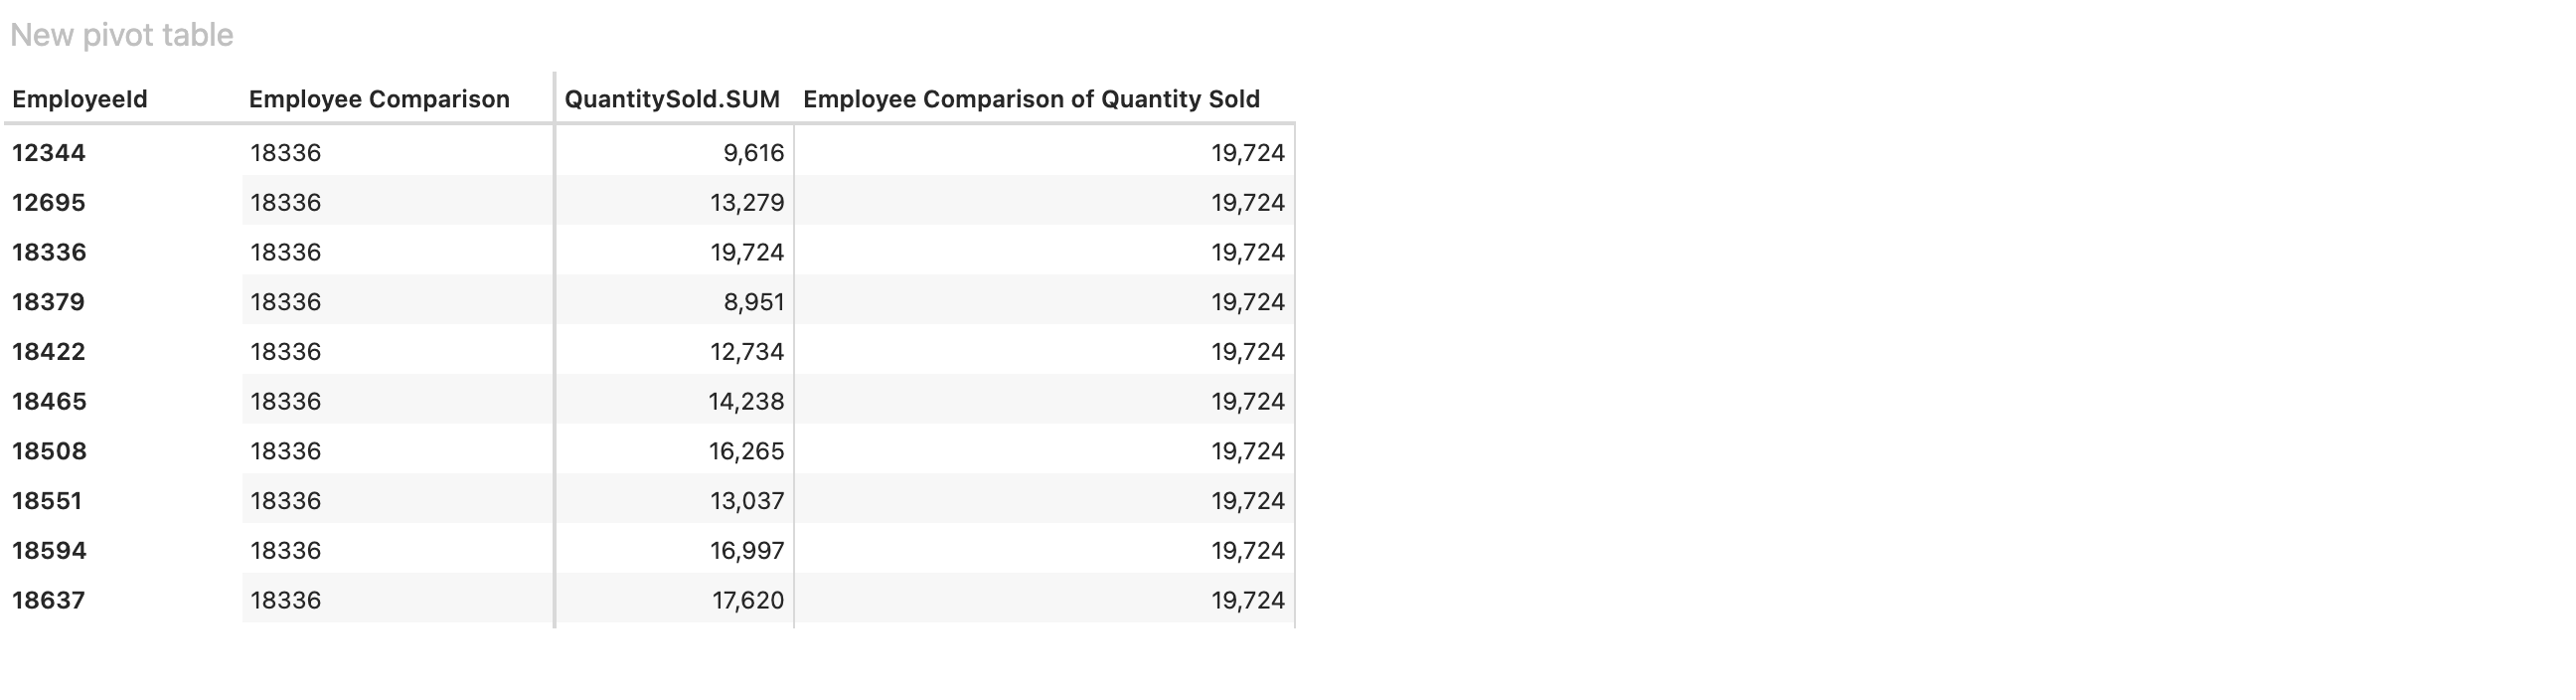

In [25]:
session.widget

Circling back to the concept of slicing hierarchies, notice that we do not see any grand totals. This is intended, as aggregating the values of the members of our parameter hierarchy at the top-level would not make sense in this case.

And when we perform a check using the `slicing` property for our new parameter hierarchy, we can see that `Employee Comparison` is indeed a slicing hierarchy.

In [26]:
h["Employee Comparison"].slicing

True

#### Using virtual hierarchies

A virtual hierarchy is a lightweight hierarchy implemented in Atoti that offers a smaller memory footprint by not storing its members in the cube. This helps optimize/save resources when dealing with hierarchies that have high cardinality or many possible distinct values. Usually, these are identifiers such as User ID, Shopping Cart ID, or Trade ID, where the hierarchy can have thousands of distinct values.

The [virtual](https://docs.atoti.io/latest/api/atoti.Hierarchy.virtual.html) hierarchy property, which when assigned either `True` or `False`, determines whether the hierarchy is a virtual hierachy or not, respectively.

> **Note:** Virtual hierarchies come at the cost of trade-offs, see the [virtual hierarchies](../virtual-hierarchies/main.ipynb) notebook to delve deeper into virtual hierarchies.

Let's take a look at a hierarchy that has a high amount of cardinality within our data model, such as the `OrderId` hierarchy.

In [27]:
orders_table = session.tables["Orders"]
m["Distinct OrderId"] = tt.agg.count_distinct(orders_table["OrderId"])

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
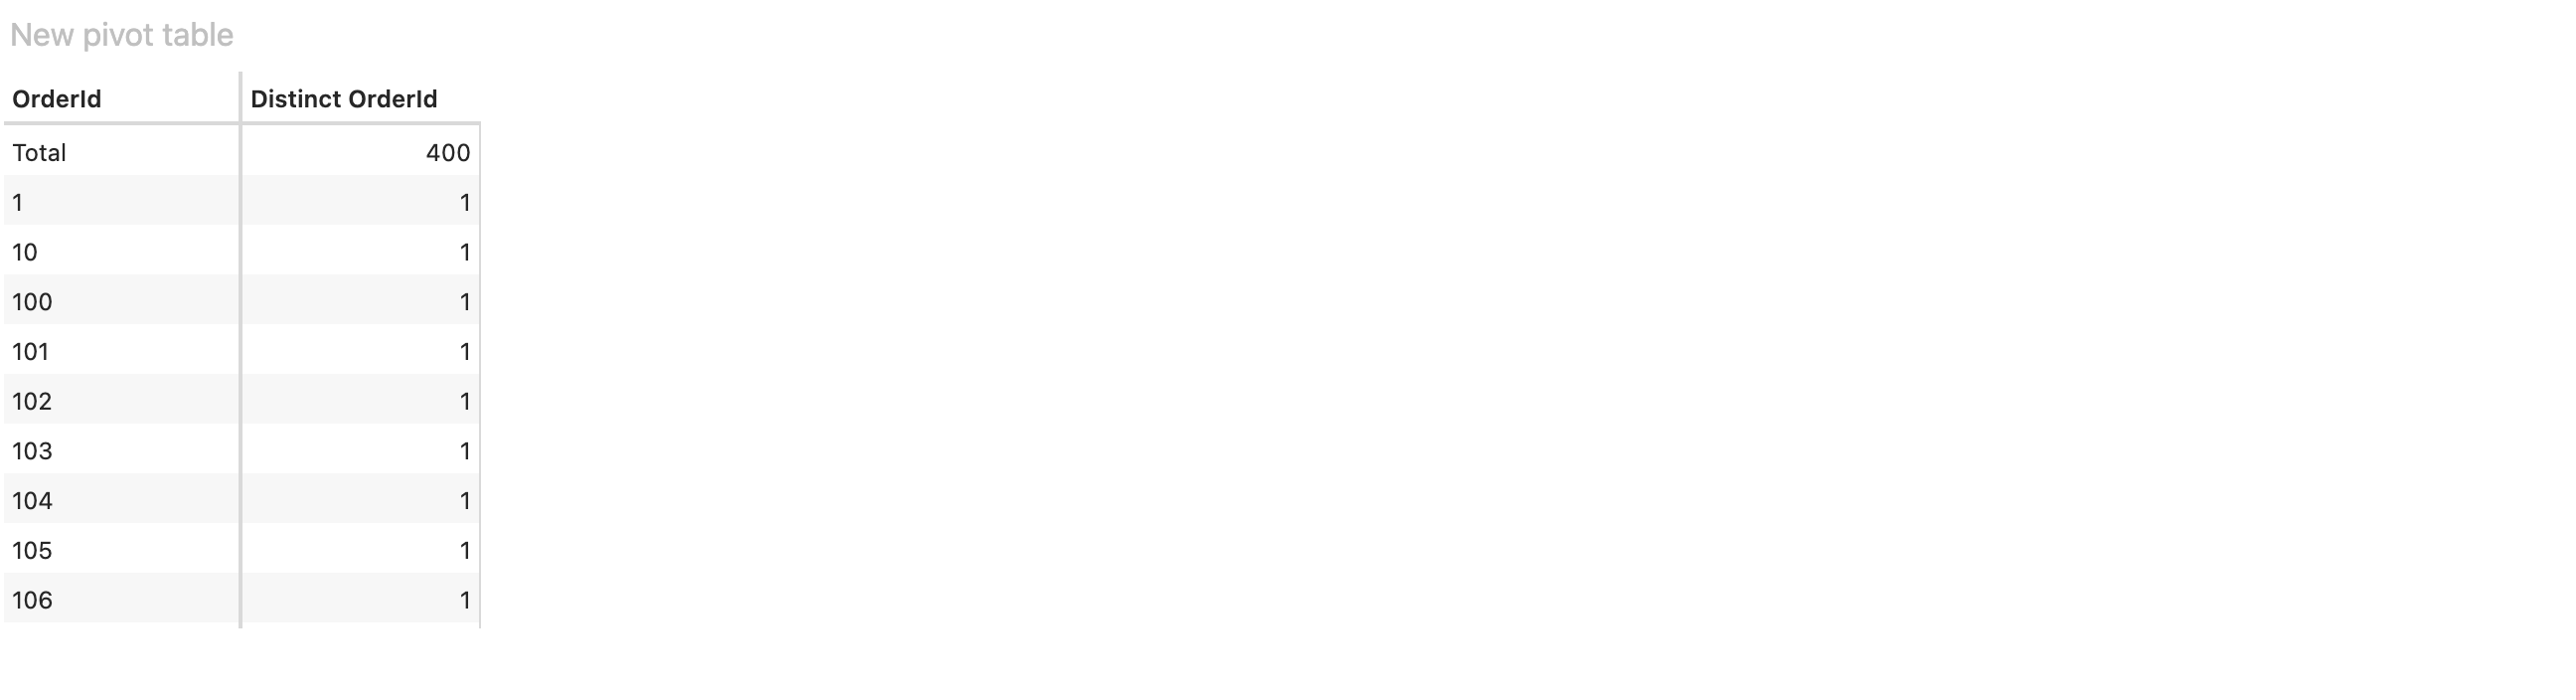

In [28]:
session.widget

Here we see that we have `400` members for the `OrderId` hierarchy. When we check if the `OrderId` hierarchy is a virtual hierarchy, it shows as `False`.

In [29]:
h["OrderId"].virtual

False

Now let's take a look at our Atoti Server logs to see the current memory footprint that we're using for the cube.

In [30]:
session.logs_path

PosixPath('/Users/aya/.atoti/1717773534_U075YE/logs/server.log')

2024-06-03T12:23:09.569-04:00  INFO 55053 --- [activepivot-health-event-dispatcher] c.a.h.m.ILoggingHealthEventHandler       : [jvm, memory] INFO 2024-06-03T16:23:09.565Z uptime=38573ms com.activeviam.health.monitor.impl.JvmHealthCheck.createEvent:61 thread=activeviam-health-check-worker thread_id=40 event_type=JvmMemoryReport JVM Memory Usage report: G1 Young Generation[count=9 (+0), time=0s (+0)]  G1 Old Generation[count=0 (+0), time=0s (+0)]  **Heap[used=377 MiB 514 KiB (395839872)** (+(0)), committed=1 GiB (1073741824) (+(0)), max=10 GiB (10737418240) (+(0))]  **Direct[used=182 MiB 413 KiB (191263933)** (+(0)), count=1024 (+0), max=10 GiB (10737418240) (+(0))]  Threads[count=84 (+0), peak=84 (+0)

If we now set the `virtual` property of the `OrderId` hierarchy to `True`, we should see a difference in memory footprint when we check our Atoti Server logs again.

In [31]:
h["OrderId"].virtual = True
h["OrderId"].virtual

True

2024-06-03T12:24:09.575-04:00  INFO 55053 --- [activepivot-health-event-dispatcher] c.a.h.m.ILoggingHealthEventHandler       : [jvm, memory] INFO 2024-06-03T16:24:09.575Z uptime=98583ms com.activeviam.health.monitor.impl.JvmHealthCheck.createEvent:61 thread=activeviam-health-check-worker thread_id=40 event_type=JvmMemoryReport JVM Memory Usage report: G1 Young Generation[count=9 (+0), time=0s (+0)]  G1 Old Generation[count=0 (+0), time=0s (+0)]  **Heap[used=425 MiB 514 KiB (446171520)** (+24 MiB (25165824)), committed=1 GiB (1073741824) (+(0)), max=10 GiB (10737418240) (+(0))]  **Direct[used=200 MiB 413 KiB (210138365)** (+9 MiB (9437184)), count=1096 (+36), max=10 GiB (10737418240) (+(0))]  Threads[count=83 (-1), peak=84 (+0)]

And that's it! Great job, this concludes our next lesson with hierarchies in Atoti! 🎉

We hope that this walk through gives you a further jump start for working with hierarchies in Atoti 😊. Stay tuned for more advanced topics on Atoti hierarchies in the future! Until then, take care! 👋

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=hierarchy-manipulations" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>